Библиотеки которые можно использовать: librosa, NMFToolbox, Nimfa, Mido/Pretty_midi,MIDIUtil.

Из всех библиотек с реализацией NMF пока остановился на Nimfa, не пойдет с ней - буду пробовать работать с NMFToolbox. Перед тем как запускать код дальше надо установить Nimfa.

In [1]:
pip install nimfa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 43.5 MB/s eta 0:00:00


In [2]:
!grep -rl "np.mat" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/np.mat/np.asmatrix/g'
!grep -rl "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/asmatrixrix/asmatrix/g'
!grep -R "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa

**Читаем исходный файл**

In [3]:
from scipy.io import wavfile
import numpy as np
import librosa
import nimfa
gamma = 1
fft_bins = 2048
f_s, x = wavfile.read("/content/FMP_C8_F27_Chopin_Op028-04.wav")
print(f_s)        # sample rate
print(x.dtype)   # int16, int32, etc.
print(x.shape)   # (N,) mono or (N, channels)
print(x[100000])
def init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, R))
    for r in range(R):
        W[:, r] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W
'''def init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix with onsets for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x (2R) with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, 2*R))
    for r in range(R):
        W[:, 2*r] = 0.1
        W[:, 2*r+1] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W'''
def template_pitch(K, pitch, freq_res, tol_pitch=0.05):
    """Defines spectral template for a given pitch

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch (float): Fundamental pitch
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        template (np.ndarray): Nonnegative template vector of size K
    """
    max_freq = K * freq_res
    pitch_freq = 2**((pitch - 69) / 12) * 440
    max_order = int(np.ceil(max_freq / ((1 - tol_pitch) * pitch_freq)))
    #print(max_freq,pitch_freq,max_order)
    template = np.zeros(K)
    for m in range(1, max_order + 1):
        min_idx = max(0, int((1 - tol_pitch) * m * pitch_freq / freq_res))
        max_idx = min(K-1, int((1 + tol_pitch) * m * pitch_freq / freq_res))
        template[min_idx:max_idx+1] = 1 / m
    return template
'''def pitch(p):
  return 2**((p-69)/12) * 440
def interval(freq, cents=20):
  return (freq * 2 ** (-cents/1200), freq * 2 ** (cents/1200))'''
if(x.dtype==np.int32):
  x = x / (2**31)
elif(x.dtype==np.int16):
  x = x / (2**15)
else:
  raise ValueError(f"Unsupported sample type: {x.dtype}")
spectrogram = np.abs(librosa.stft(x, n_fft=fft_bins,hop_length=1024))
spectrogram_compressed = np.log(1+gamma*spectrogram)
print(x[100000])
print(np.min(spectrogram_compressed),np.max(spectrogram_compressed))
print(spectrogram_compressed.shape)
pitches = [x+21 for x in range(88)]
freq_res = f_s/(fft_bins)
print(freq_res)
W_temp = init_nmf_template_pitch(fft_bins//2+1,pitches,freq_res)
H_temp = np.random.rand(88, spectrogram_compressed.shape[1])
#nmf = nimfa.Nmf(spectrogram_compressed, seed='fixed', W=W_temp)
nmf = nimfa.Nmf(
    spectrogram_compressed,
    rank=88,
    seed='fixed',
    W=W_temp,
    H=H_temp,
    max_iter=200,
    beta=1, sparsity=(None, 0.2)
)
nmf_fit = nmf()
W_est = nmf_fit.basis()
H_est = nmf_fit.coef()

/usr/local/lib/python3.12/dist-packages/nimfa/models/nmf.py:589: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if self.seed is not None and self.seed is not "fixed":
/usr/local/lib/python3.12/dist-packages/nimfa/methods/seeding/random.py:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if sn[0] is 'S' and sn[1:].isdigit():
/usr/local/lib/python3.12/dist-packages/nimfa/methods/factorization/sepnmf.py:276: SyntaxWarning: invalid escape sequence '\m'
  .. math:: \arg\min_{Y \ge 0} \| V - W H \|_F.


44100
int16
(427392,)
1197
0.036529541015625
1.8986922075067998e-07 5.586010323094518
(1025, 418)
21.533203125


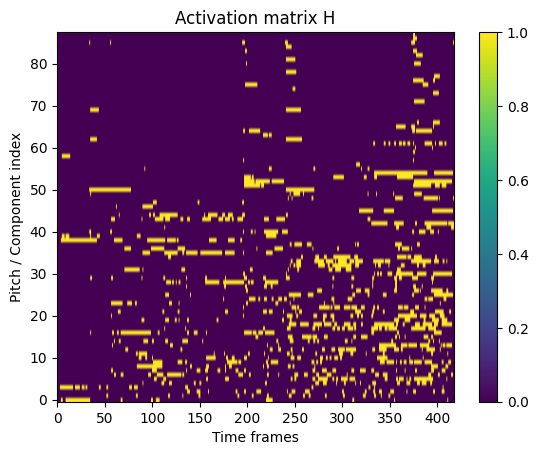

In [8]:
#print(W_est.shape)
#print(H_est[:,100])
import matplotlib.pyplot as plt
#H_est_visualisation = np.log(1+10*H_est)
from scipy.signal import butter, filtfilt

b, a = butter(2, 0.1)   # low-pass along time
#H_est_visualisation = filtfilt(b, a, H_est, axis=1)
#H_est_visualisation = np.log(1+10*H_est[1::2,:])
#H_est_visualisation = filtfilt(b, a, H_est_visualisation, axis=1)
#print(H_est[1::2].shape)
#print(np.percentile(H_est[1::2],95))
H_n = np.log(1+H_est)
'''def note_tracking(H,threshold=2e-2):
  H_res = np.zeros(H.shape)
  print(type(H))
  print(H.shape)
  for q in range(H.shape[0]):
    for t in range(H.shape[1]):
      h_qt = 0
      for j in range(-10,11):
        if((t+j)>=0 and (t+j)<=(H.shape[1]-1)):
          h_qt += H[q,t+j]
          #print("q=",q)
          #print("t+j=",t+j)
          #print("h_qt=",h_qt)
      #print("h_qt=",h_qt)
      h_qt = h_qt / 21 + threshold
      if(H[q,t]>h_qt):
        H_res[q,t] = 1
  return H_res'''
def note_tracking(H,th=1.5):
  mean = np.mean(H)
  std = np.std(H)
  thresh = mean + th * std
  H_copy = np.zeros(H.shape)
  for i in range(H.shape[1]):
    indicies = np.where(H[:,i] > thresh)
    H_copy[indicies,i] = 1
  return H_copy
from scipy.ndimage import gaussian_filter1d
H_n = gaussian_filter1d(H_n, sigma=1.0, axis=1)
H_s = note_tracking(H_n)
plt.figure()
#plt.imshow(np.log(1+200*H_est[1::2]), aspect='auto', origin='lower')
plt.imshow(H_s, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

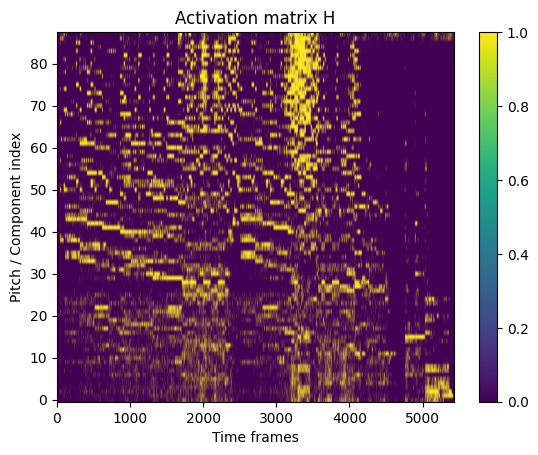

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d, binary_opening, binary_closing, label
from scipy.ndimage import generate_binary_structure


def clean_H_median(H, t_kernel=9, p_kernel=3):
    return medfilt(H, kernel_size=(p_kernel, t_kernel))

def note_tracking_percentile(H, q=85):
    H = np.asarray(H)  # CRITICAL
    H_bin = np.zeros(H.shape, dtype=np.uint8)

    for p in range(H.shape[0]):
        row = H[p].ravel()              # ensure 1D
        thresh = np.percentile(row, q)
        H_bin[p] = row > thresh

    return H_bin
def remove_short_events(H, min_len=10):
    H2 = H.copy()
    for k in range(H.shape[0]):
        active = np.where(H[k] > 0)[0]
        if len(active) == 0:
            continue
        runs = np.split(active, np.where(np.diff(active) != 1)[0] + 1)
        for r in runs:
            if len(r) < min_len:
                H2[k, r] = 0
    return H2
def pitch_support_filter(H, min_neighbors=1):
    H2 = H.copy()
    for k in range(1, H.shape[0]-1):
        support = H[k-1] + H[k] + H[k+1]
        H2[k, support < min_neighbors] = 0
    return H2
#res = pitch_support_filter(remove_short_events(note_tracking(H_est[1::2])))
#res = remove_short_events(note_tracking(H_est[1::2]))
H_new = H_est[1::2].copy()
res = note_tracking_percentile(H_new)
#print(res[0].shape)
#H_est_vis = note_tracking_simple(H_est)
plt.figure()
#plt.imshow(H_est[1::2,],aspect='auto', origin='lower')
plt.imshow(res,aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

In [ ]:
tempo, beats = librosa.beat.beat_track(y=x, sr=f_s)

tempo = float(tempo)          # or: tempo = tempo.item()

print(f"Estimated tempo: {tempo:.2f} BPM")

beat_times = librosa.frames_to_time(beats, sr=f_s)
print(f"Beat positions (sec.): {beat_times}")

Estimated tempo: 107.67 BPM
Beat positions (sec.): [ 0.99845805  1.56734694  2.13623583  2.55419501  3.14630385  3.7384127
  4.31891156  4.89941043  5.4799093   6.06040816  6.64090703  7.2214059
  7.80190476  8.38240363  8.96290249  9.54340136 10.11229025 10.68117914
 11.23845805 11.79573696 12.35301587 12.91029478 13.4675737  14.02485261
 14.58213152 15.13941043 15.68507937 16.2307483  16.77641723 17.32208617
 17.8677551  18.41342404 18.95909297 19.5047619  20.05043084 20.63092971
 21.19981859 21.78031746 22.34920635 22.92970522 23.51020408 24.09070295
 24.65959184 25.2400907  25.82058957 26.40108844 26.9815873  27.56208617
 28.14258503 28.71147392 29.28036281 29.8492517  30.40653061 30.98702948
 31.56752834 32.14802721 32.72852608 33.29741497 33.86630385 34.44680272
 35.02730159 35.60780045 36.18829932 36.75718821 37.3260771  37.89496599
 38.46385488 39.03274376 39.60163265 40.15891156 40.72780045 41.28507937
 41.8307483  42.41124717 42.96852608 43.52580499 44.12952381 44.72163265
 4

/tmp/ipython-input-3247953737.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo = float(tempo)          # or: tempo = tempo.item()


# Попробуем готовый NMFD

In [ ]:
from scipy.io import wavfile
import numpy as np
import librosa
from convolutive_MM import convlutive_MM
import torch
from torchnmf.nmf import NMFD
gamma = 1
f_s, x = wavfile.read("/content/FChopinPreludeOp28n4.wav")
if(x.dtype==np.int32):
  x = x / (2**31)
elif(x.dtype==np.int16):
  x = x / (2**15)
else:
  raise ValueError(f"Unsupported sample type: {x.dtype}")
X = np.abs(librosa.stft(x, n_fft=2048,hop_length=1024))
print(f_s)        # sample rate
print(x.dtype)   # int16, int32, etc.
print(x.shape)   # (N,) mono or (N, channels)
print(x[100000])
def cnmf(V, n_components=8, n_lags=10, n_iter=100, eps=1e-9):
    """
    V: (F, T) non-negative matrix (e.g. magnitude spectrogram)
    W: (F, K, L)
    H: (K, T)
    """
    F, T = V.shape
    K = n_components
    L = n_lags

    # initialize
    W = np.random.rand(F, K, L)
    H = np.random.rand(K, T)

    for it in range(n_iter):
        print("Iteration number:",it)
        # reconstruct V_hat
        V_hat = np.zeros_like(V)
        for k in range(K):
            for l in range(L):
                V_hat[:, l:] += np.outer(W[:, k, l], H[k, :-l or None])

        # update H
        for k in range(K):
            num = np.zeros(T)
            den = np.zeros(T) + eps
            for l in range(L):
                Wkl = W[:, k, l][:, None]
                num[l:] += (Wkl * V[:, l:]).sum(axis=0)
                den[l:] += (Wkl * V_hat[:, l:]).sum(axis=0)
            H[k] *= num / den

        # update W
        for k in range(K):
            for l in range(L):
                num = (V[:, l:] * H[k, :-l or None]).sum(axis=1)
                den = (V_hat[:, l:] * H[k, :-l or None]).sum(axis=1) + eps
                W[:, k, l] *= num / den

        if it % 10 == 0:
            err = np.linalg.norm(V - V_hat)
            print(f"iter {it:3d} | error {err:.3f}")

    return W, H
#res = cnmf(X,88,10,100,eps=1e-9)
S = torch.from_numpy(X).float().unsqueeze(0)
model = NMFD(S.shape, rank=88, T=10)  # rank = components, T = time lags
model.fit(S, max_iter=100)
# Extract factors
W = model.W.detach().cpu().numpy()  # (F, rank, T)
H = model.H.detach().cpu().numpy()  # (batch, rank, time)

# Remove batch dimension from H
H = H[0]

/tmp/ipython-input-158322369.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  f_s, x = wavfile.read("/content/FChopinPreludeOp28n4.wav")


44100
float64
(5556600,)
-0.105194091796875


In [ ]:
pip install torchnmf

In [ ]:
print(H.shape)
print(H[:,100])

(88, 5418)
[2.83473209e-08 6.50976878e-03 1.41789596e-05 1.52520073e-07
 6.73773190e-11 6.32580509e-03 4.19024815e-07 1.45695822e-07
 5.12761474e-02 5.86620565e-08 2.48410529e-03 1.86016359e-06
 3.35856169e-11 2.82648742e-01 6.40907327e-10 4.86882832e-13
 1.54526517e-01 1.78778432e-02 8.55022892e-02 2.62964522e-06
 1.24121982e-06 3.14110337e-04 2.75774291e-05 2.64729764e-02
 1.51610147e-05 1.17561613e-04 4.98511456e-03 2.54663263e-07
 8.55225977e-03 9.62969295e-08 7.92492528e-07 5.81414402e-01
 1.42720955e-08 7.23814758e-11 1.23293276e-09 3.87781256e-08
 1.10994971e+00 1.21309212e-08 3.84029475e-09 1.08044292e-03
 5.38210334e-05 6.71427081e-10 7.98618771e-07 3.76486016e-04
 3.88029031e-04 3.47614923e-06 4.01852667e-01 3.48497309e-07
 5.86884730e-02 3.26614757e-03 5.65014835e-09 1.82239184e-08
 7.23177118e-09 3.41943360e-06 1.21501932e+01 1.63683857e-20
 1.53367546e-05 1.36501212e-02 1.72257292e-04 5.52130332e-05
 1.34814968e-06 4.82613547e-03 5.68299438e-04 7.87530690e-02
 1.91205490e-

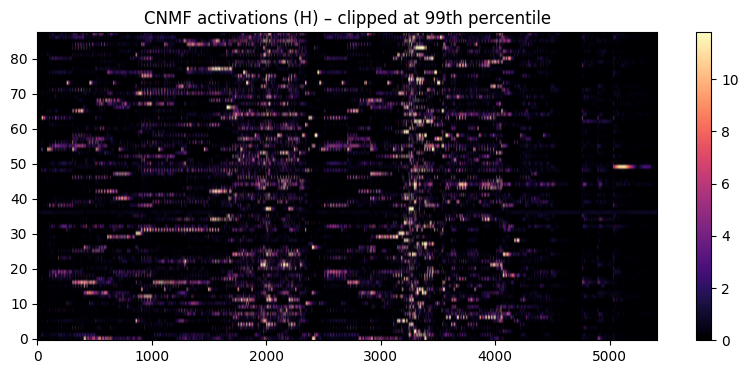

In [ ]:
import matplotlib.pyplot as plt

vmax = np.percentile(H, 99)

plt.figure(figsize=(10,4))
plt.imshow(
    H,
    aspect='auto',
    origin='lower',
    cmap='magma',
    vmin=0,
    vmax=vmax
)
plt.colorbar()
plt.title("CNMF activations (H) – clipped at 99th percentile")
plt.show()

# Пробуем CNMF (имплементация из libnmfd)

In [ ]:
pip install libnmfd

# Обнаружение начал нот (Onsets detection)

Будем использовать подход, называемый Spectral Difference, вычисляя результат по формуле вот отсюда: https://www.iro.umontreal.ca/~pift6080/H09/documents/presentations/xavier_bello_tutorial.pdf

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


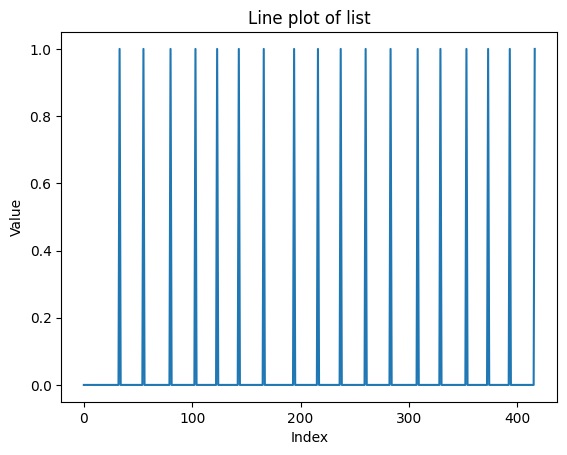

In [ ]:
def H(x):
  return (x+abs(x))/2
def summf(v1,v2):
  #v1 - spectral coefficients vector at moment n
  #v2 - spectral coefficients vector at moment (n+1)
  l = v1.shape[0]
  assert l == v2.shape[0]
  s = 0
  for i in range(l):
    s += (H(v2[i]-v1[i]))**2
  return s
def spec_diff(sp):
  res = []
  for i in range(sp.shape[1]-1):
    res.append(float(summf(sp[:,i],sp[:,i+1])))
  return res
H(5)
def eval_thrshld(d,n,M=100,abs_thrsh=0.1,lam=1.0):
  r = abs_thrsh
  n_s = n-M
  n_f = n+M
  if(n<M):
    n_s = M
  if(n+M>=len(d)):
    n_f = len(d)
  r += lam * np.median(d[n_s:n_f])
  return r
def peak_detect(data):
  res = np.zeros((len(data),))
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res[i] = 1
      lval = i
  return res
import matplotlib.pyplot as plt



In [27]:
import numpy as np
def shift_right(x, k):
    if(k==0):
      return x
    y = np.zeros_like(x)
    y[k:] = x[:-k]
    return y
def note_template(pitch, alpha=0.5):
  r = np.zeros((88,))
  #first eight harmonics of some pitch
  l = [0,12,19,24,28,31,34,36]
  r[l]=1
  #print(pitch)
  r = shift_right(r,pitch)
  return r
def top_k_indices(v, k):
    return np.argsort(v)[-k:][::-1]
def rms(x):
    return np.sqrt(np.mean(np.square(x)))
def process_frame(s,k=3,en_thrsh=0.4):
    assert s.shape[0] == 88 and s.shape[1] == 1
    notes = []
    s_c = s.copy()
    s_c = np.asarray(s, dtype=float).squeeze()
    #print(type(s_c))
    #print("s_c=",s_c)
    s_pitches = top_k_indices(s_c,k)
    #print("s_pitches=",s_pitches)
    for l in s_pitches:
      #print(l)
      r = rms(np.dot(note_template(l),s_c))
      #print("r=",r)
      if(r>en_thrsh):
        notes.append(int(l))
    return notes
def note_tracking(mtr):
  r = np.zeros(mtr.shape)
  for i in range(mtr.shape[1]):
    ind = process_frame(mtr[:,i])
    for k in ind:
      r[k,i] = 1
  return r

(88, 418)
(88, 418)
(88,)


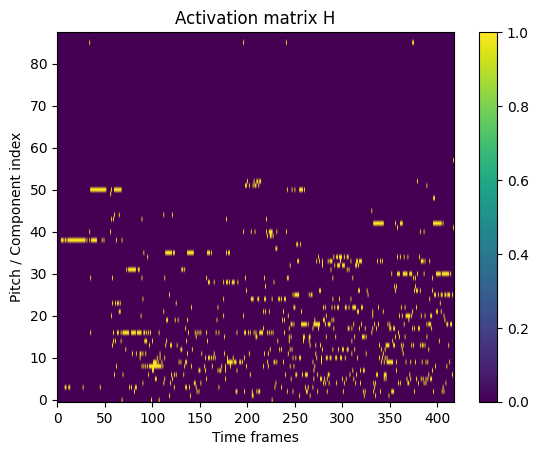

In [29]:
H_n = np.log(1+H_est)
print(H_n.shape)
H_n = note_tracking(H_est)
print(H_n.shape)
print(H_n[:,100].shape)

plt.figure()
#plt.imshow(np.log(1+200*H_est[1::2]), aspect='auto', origin='lower')
plt.imshow(H_n, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

In [9]:
print(H_s.shape)

(88, 418)


In [ ]:
print(note_template(0))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
v=[3,7,5,2,7,8,9,1,2,3,5,6,7,8,9,2,]
def top_k_indices(v, k):
    return np.argsort(v)[-k:][::-1]
print(top_k_indices(v, 9))

[14  6  5 13  1  4 12 11  2]
